In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Cargar datos ---
df = pd.read_excel("public_emdat_2025-12-09.xlsx")

# Normalizar nombres de columnas (quita espacios raros)
df.columns = df.columns.str.strip()

# --- Columnas numéricas típicas (ajusta si tu excel tiene otros nombres) ---
columnas_numericas = [
    "Total Deaths",
    "Total Affected",
]

# Convertir a numérico si existen
for col in columnas_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Detectar automáticamente columna de daños/pérdidas económicas
col_danios = None
for col in df.columns:
    if "Damage" in col or "Damages" in col:
        col_danios = col
        df[col_danios] = pd.to_numeric(df[col_danios], errors="coerce").fillna(0)
        break

print("Columna de daños detectada:", col_danios)

# Eliminar registros sin país o tipo de desastre
df = df.dropna(subset=["Country", "Disaster Type"])


Columna de daños detectada: Insured Damage ('000 US$)


In [2]:
class DesastresNaturales:
    def __init__(self, dataframe):
        self.df = dataframe

    def tabla_por_pais(self):
        if self.df.empty:
            return pd.DataFrame()
        return (
            self.df["Country"]
            .value_counts()
            .reset_index(name="Cantidad de Desastres")
            .rename(columns={"index": "País"})
        )

    def tipos_frecuentes(self):
        if self.df.empty:
            return pd.Series(dtype=int)
        return self.df["Disaster Type"].value_counts()

    def filtrar_desastre(self, tipo):
        return self.df[self.df["Disaster Type"].str.lower() == tipo.lower()]
    
    

In [3]:
class ImpactoHumano:
    def __init__(self, dataframe):
        self.df = dataframe

    def muertes_por_desastre(self):
        if self.df.empty:
            return pd.Series(dtype=int)

        return (
            self.df
            .groupby("Disaster Type")["Total Deaths"]
            .sum()
            .sort_values(ascending=False)
        )

    def impacto_por_subtipo(self):
        if self.df.empty:
            return pd.DataFrame()

        return (
            self.df
            .groupby("Disaster Subtype")[["Total Deaths", "Total Affected"]]
            .sum()
            .sort_values(by="Total Deaths", ascending=False)
        )


In [4]:
class ImpactoEconomico:
    def __init__(self, dataframe, columna_danios):
        self.df = dataframe
        self.columna_danios = columna_danios

    def perdidas_por_desastre(self):
        if self.df.empty or self.columna_danios not in self.df.columns:
            return pd.Series(dtype=float)

        return (
            self.df.groupby("Disaster Type")[self.columna_danios]
            .sum()
            .sort_values(ascending=False)
        )

In [5]:
class AnalisisKMeans:

    def __init__(self, df):
        self.df = df

    def aplicar_kmeans_por_tipo(self, k=3):
        # 1️⃣ Agrupar por tipo de desastre
        df_group = self.df.groupby("Disaster Type")[[
            "Total Deaths", "Total Affected"
        ]].sum()

        # 2️⃣ 🔴 AQUÍ VA EL EPSILON (ESTE ES EL LUGAR CORRECTO)
        epsilon = 1
        df_group["Total Deaths"] += epsilon
        df_group["Total Affected"] += epsilon

        # 3️⃣ Preparar datos para K-Means
        X = df_group[["Total Deaths", "Total Affected"]]

        # 4️⃣ Escalado (opcional pero recomendado)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 5️⃣ K-Means
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        df_group["Cluster"] = kmeans.fit_predict(X_scaled)

        return df_group

In [6]:
class Visualizador:

    def tabla(self, df):
        if df.empty:
            print("⚠️ No hay datos para mostrar.")
            return
        display(df)

    def grafica_barras(self, serie, titulo, ylabel):
        if serie.empty:
            print("⚠️ No hay datos para generar la gráfica.")
            return

        serie.plot(
            kind="bar",
            figsize=(10,5)
        )

        plt.title(titulo)
        plt.ylabel(ylabel)
        plt.xlabel("Categoría")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


    def grafica_afectados_vs_muertes(self, df):
            if df.empty:
                print("⚠️ No hay datos para graficar")
                return

            df = df.copy()

            # Conversión segura
            df["Total Deaths"] = pd.to_numeric(df["Total Deaths"], errors="coerce").fillna(0)
            df["Total Affected"] = pd.to_numeric(df["Total Affected"], errors="coerce").fillna(0)

            # Quitar subtipos nulos
            df = df.dropna(subset=["Disaster Subtype"])

            # Agrupar
            tabla_inundaciones = (
                df.groupby("Disaster Subtype")[["Total Deaths", "Total Affected"]]
                .sum()
                .reset_index()
            )

            if tabla_inundaciones.empty:
                print("⚠️ No hay datos agrupados")
                return

            # Renombrar columnas para la gráfica
            tabla_inundaciones = tabla_inundaciones.rename(columns={
                "Total Deaths": "muertes_totales",
                "Total Affected": "afectados_totales"
            })

            # ORDENAR (como en tu código)
            tabla_plot = tabla_inundaciones.sort_values(
                "afectados_totales", ascending=True
            ).copy()

            # === GRÁFICA ===
            x = np.arange(len(tabla_plot))
            w = 0.4

            plt.figure(figsize=(10, 4))
            plt.bar(x - w/2, tabla_plot["muertes_totales"], width=w, label="Muertes")
            plt.bar(x + w/2, tabla_plot["afectados_totales"], width=w, label="Afectados")

            # Escala log (como pediste)
            plt.yscale("log")

            plt.xticks(x, tabla_plot["Disaster Subtype"], rotation=20, ha="right")
            plt.title("Muertes vs Afectados por subtipo (escala log)")
            plt.ylabel("Total (log)")
            plt.legend()
            plt.tight_layout()
            print("Mostrando gráfica...")
            plt.show()



    def grafica_kmeans_por_tipo(self, tabla):
        if tabla.empty:
            print("⚠️ No hay datos para K-Means")
            return

        plt.figure(figsize=(9,6))

        for cluster in sorted(tabla["Cluster"].unique()):
            datos = tabla[tabla["Cluster"] == cluster]

            plt.scatter(
                datos["Total Deaths"],
                datos["Total Affected"],
                label=f"Cluster {cluster}",
                s=100
            )

        # Escalas log
        plt.xscale("log")
        plt.yscale("log")

        plt.xlabel("Muertes Totales (log)")
        plt.ylabel("Afectados Totales (log)")
        plt.title("K-Means por Tipo de Desastre (Impacto Humano)")
        plt.legend()
        plt.tight_layout()
        plt.show()




MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


,Country,Cantidad de Desastres
0,China,1374
1,India,842
2,United States of America,737
3,Indonesia,584
4,Philippines,488
...,...,...
218,Saint Barthélemy,1
219,Sint Maarten (Dutch part),1
220,Curaçao,1
221,Liechtenstein,1



MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


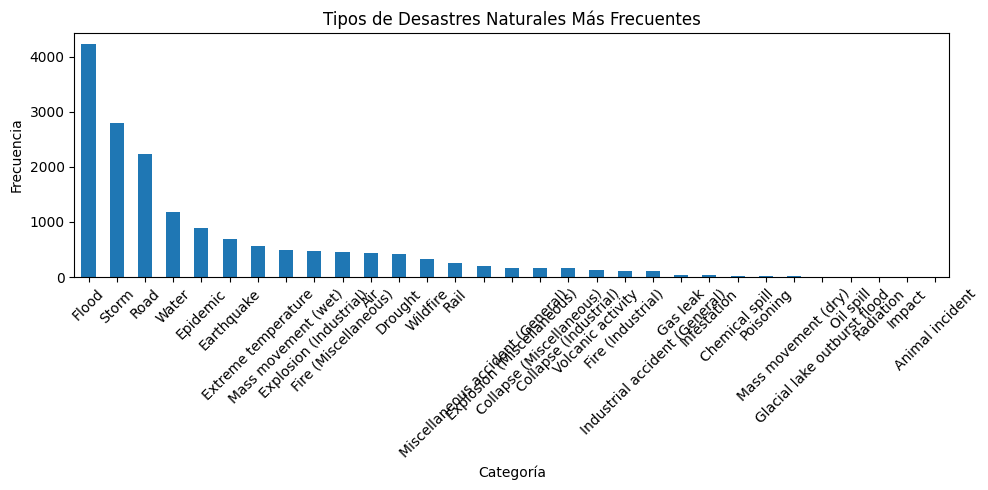


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


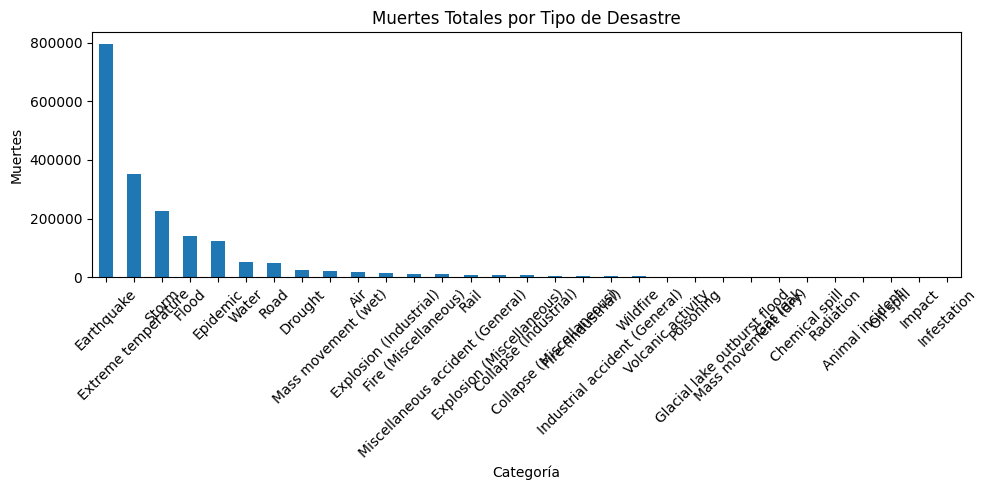


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


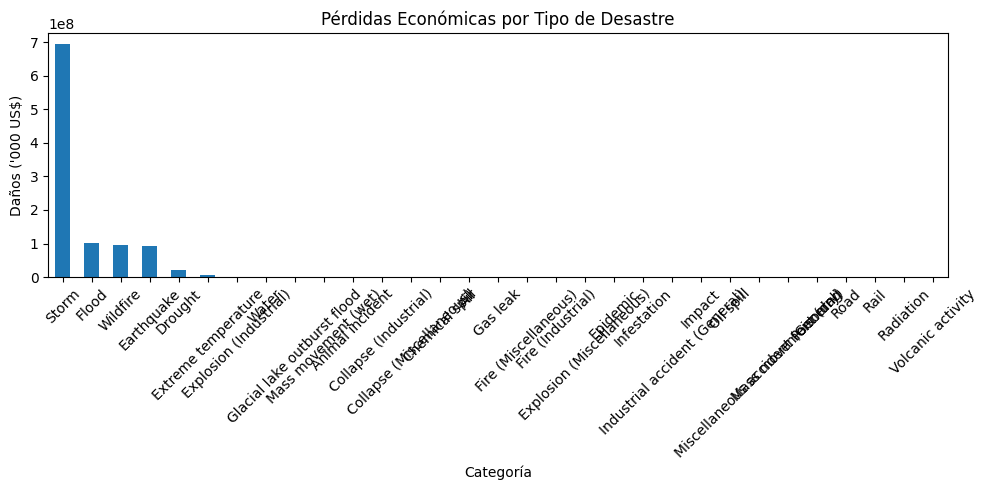


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


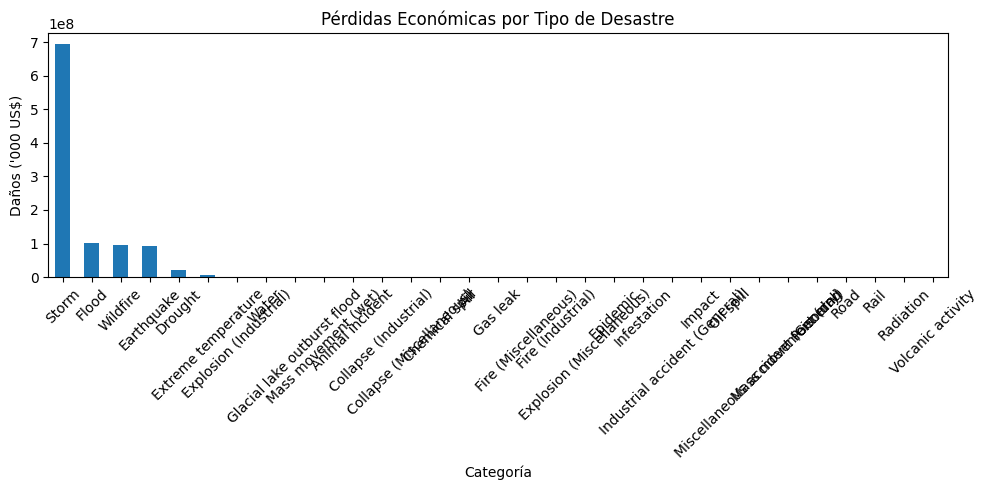


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir
Mostrando gráfica...


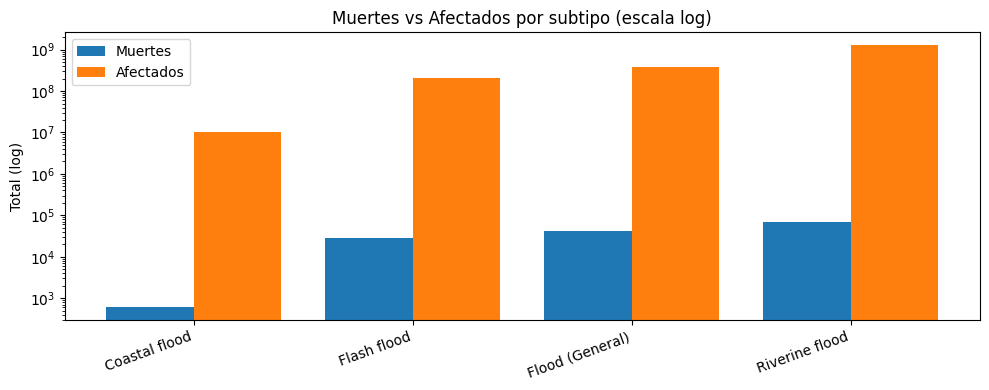


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir


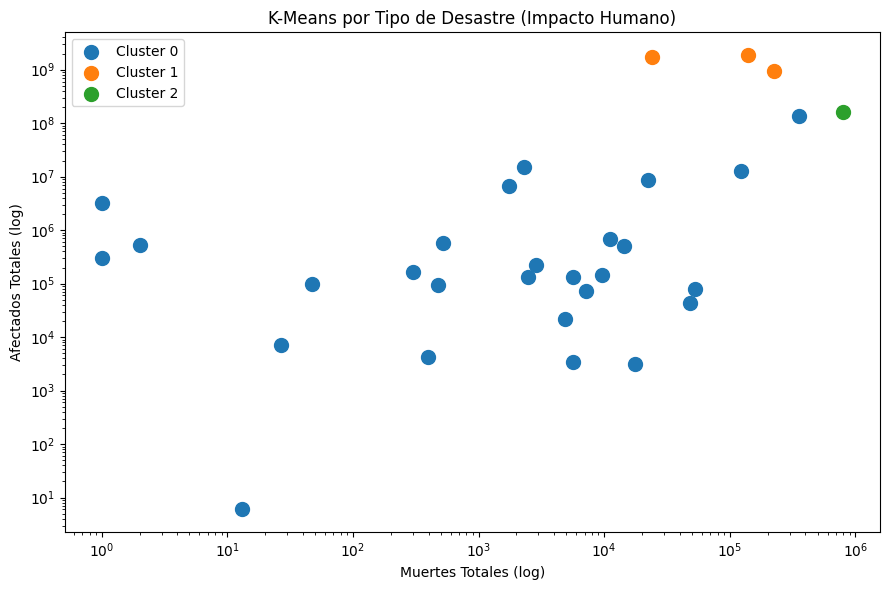


MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir
Opción inválida. Intenta nuevamente.

MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir
Opción inválida. Intenta nuevamente.

MENÚ – ANÁLISIS DE DESASTRES NATURALES
1. Tabla de desastres por países
2. Gráfica del tipo de desastre más frecuente
3. Gráfica de desastres que causan más muertes
4. Gráfica de desastres con mayor pérdida económica
5. Análisis por subtipos (muertes y afectados)
6. Análisis K-Means
7. Salir
Opción inválida. Intenta nuevamente.

MENÚ –

In [ ]:
desastres = DesastresNaturales(df)
viz = Visualizador()

while True:
    print("\nMENÚ – ANÁLISIS DE DESASTRES NATURALES")
    print("1. Tabla de desastres por países")
    print("2. Gráfica del tipo de desastre más frecuente")
    print("3. Gráfica de desastres que causan más muertes")
    print("4. Gráfica de desastres con mayor pérdida económica")
    print("5. Análisis por subtipos (muertes y afectados)")
    print("6. Análisis K-Means")
    print("7. Salir")

    opcion = input("Selecciona una opción: ").strip()

    if opcion == "1":
        viz.tabla(desastres.tabla_por_pais())

    elif opcion == "2":
        viz.grafica_barras(
            desastres.tipos_frecuentes(),
            "Tipos de Desastres Naturales Más Frecuentes",
            "Frecuencia"
        )

    elif opcion == "3":
        impacto = ImpactoHumano(df)
        viz.grafica_barras(
            impacto.muertes_por_desastre(),
            "Muertes Totales por Tipo de Desastre",
            "Muertes"
        )

    elif opcion == "4":
        impacto = ImpactoEconomico(df, col_danios)
        viz.grafica_barras(
            impacto.perdidas_por_desastre(),
            "Pérdidas Económicas por Tipo de Desastre",
            "Daños ('000 US$)"
        )
    elif opcion == "5":
        tipo = input("Escribe el tipo de desastre (ej. Flood, Earthquake): ").strip()

        df_filtrado = desastres.filtrar_desastre(tipo)

        if df_filtrado.empty:
            print("No existen registros para ese tipo de desastre.")
            continue

        viz.grafica_afectados_vs_muertes(df_filtrado)
        
    elif opcion == "6":
        analisis = AnalisisKMeans(df)
        resultado = analisis.aplicar_kmeans_por_tipo(k=3)
        viz.grafica_kmeans_por_tipo(resultado)


    elif opcion == "7":
        print("Programa finalizado correctamente.")
        break

    else:
        print("Opción inválida. Intenta nuevamente.")